In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
ocr_dir = "/content/drive/My Drive/OCR_output"

In [3]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 43.6 MB/s eta 0:00:00


# Load and normalize OCR text

In [4]:
import os

agreements = {}

for state_dir in os.listdir(ocr_dir):
    state_path = os.path.join(ocr_dir, state_dir)
    if os.path.isdir(state_path):
        for fname in os.listdir(state_path):
            if fname.endswith(".txt"):
                fpath = os.path.join(state_path, fname)
                with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                    text = f.read()
                    agreements[f"{state_dir}/{fname}"] = text
print(f"Loaded {len(agreements)} agreements.")

Loaded 298 agreements.


**Sample a small subset of agreements**

In [5]:
import random
random.seed(42)  # reproducibility

# agreements: dict {filename: text}
random.seed(42)  # reproducibility
POC_SAMPLE_SIZE = 20  # small subset for POC

sample_keys = random.sample(list(agreements.keys()), min(POC_SAMPLE_SIZE, len(agreements)))
agreements_sample = {k: agreements[k] for k in sample_keys}
print(f"Sampled {len(agreements_sample)} agreements for POC.")


Sampled 20 agreements for POC.


In [6]:
#to have correct order in list
sample_keys = list(agreements_sample.keys())
sample_texts = [agreements_sample[k] for k in sample_keys]

# Deduplication task

In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import faiss

# 1) Load Legal-SBERT model
model = SentenceTransformer("bhavyagiri/InLegal-Sbert")


# 2) Compute embeddings
embeddings = model.encode(sample_texts, convert_to_numpy=True, normalize_embeddings=True)

# 3) Build FAISS index
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)
index.add(embeddings)

# 4) Search for duplicates
SIM_THRESHOLD = 0.85
D, I = index.search(embeddings, k=2)

duplicates = []
for idx, (scores, nbrs) in enumerate(zip(D, I)):
    if nbrs[1] != idx and scores[1] >= SIM_THRESHOLD:
        duplicates.append((sample_keys[idx], sample_keys[nbrs[1]], scores[1]))

print("Duplicates found:", duplicates)

# -----------------------------
# 5) Sister Cities % calculation

sci_count = sum(1 for text in sample_texts if "Sister Cities International" in text)
percent_sci = sci_count / len(sample_texts) * 100
print(f"\nSister Cities International mentioned in {percent_sci:.2f}% of sampled agreements")

# -----------------------------
# 6) Partner-level detail (avg word count)

partner_word_counts = {}
for key, text in zip(sample_keys, sample_texts):
    first_line = text.split("\n")[0].strip()  # heuristic for partner name
    words = len(text.split())
    partner_word_counts[first_line] = partner_word_counts.get(first_line, []) + [words]

avg_words_per_partner = {p: sum(lst)/len(lst) for p, lst in partner_word_counts.items()}
sorted_avg_words = sorted(avg_words_per_partner.items(), key=lambda x: x[1], reverse=True)

print("\nTop partners by average agreement length (words):")
for p, w in sorted_avg_words[:5]:
    print(f"{p}: {w:.0f} words")

# -----------------------------
# 7) Coordination & Legal References flags

coord_keywords = ["coordination with", "in collaboration with", "jointly with"]
legal_refs_keywords = ["see", "refer to", "pursuant to", "in accordance with", "as per"]

coordination_flags = {k: any(kw in text.lower() for kw in coord_keywords)
                      for k, text in zip(sample_keys, sample_texts)}
legal_refs_flags = {k: any(kw in text.lower() for kw in legal_refs_keywords)
                    for k, text in zip(sample_keys, sample_texts)}

print("\nSample coordination flags:")
for k, flag in list(coordination_flags.items())[:5]:
    print(f"{k}: {flag}")

print("\nSample legal references flags:")
for k, flag in list(legal_refs_flags.items())[:5]:
    print(f"{k}: {flag}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Duplicates found: [('Utah/Utah_18.txt', 'Indiana/Indiana_5.txt', np.float32(0.96470404)), ('New Hampshire/NewHempshire_3.txt', 'Ohio/Ohio_2.txt', np.float32(0.9414926)), ('Texas/Texas_30.txt', 'Texas/Texas_17.txt', np.float32(0.9808413)), ('Texas/Texas_17.txt', 'Texas/Texas_30.txt', np.float32(0.9808413)), ('Maryland/Maryland_55.txt', 'Virginia/Virgina_1.txt', np.float32(0.9288901)), ('Indiana/Indiana_5.txt', 'Utah/Utah_18.txt', np.float32(0.96470404)), ('Utah/Utah_13.txt', 'California/1August23.txt', np.float32(0.9742336)), ('California/1September29.txt', 'Utah/Utah_13.txt', np.float32(0.94875526)), ('Ohio/Ohio_2.txt', 'Ohio/Ohio_8.txt', np.float32(0.9562973)), ('California/1August23.txt', 'Utah/Utah_13.txt', np.float32(0.9742336)), ('Vermont/Vermont_11.txt', 'Utah/Utah_13.txt', np.float32(0.9609138)), ('Vermont/Vermont_10.txt', 'Utah/Utah_13.txt', np.float32(0.9522643)), ('Ohio/Ohio_8.txt', 'Texas/Texas_17.txt', np.float32(0.96176535)), ('Minnesota/Minesota_4.txt', 'Vermont/Vermont_1

See that we have 0% of occurence of Sister Cities International phrase. It could be caused by using shortuct for this organization. Let's try with them:
* SCI
* Sister City
* Sister-City
* Sister Cities
* Sister Cities Program
* Sister City International
* Sister Cities Int.

In [8]:
import re

sci_patterns = [
    r"sister\s+cities\s+international",
    r"sister\s+cities\s+int\.?",
    r"sister\s+city\s+international",
    r"sister\s+cities\b",
    r"sister\s+city\b",
    r"\bsci\b"
]


In [9]:
def mentions_sci(text):
    text = text.lower()
    return any(re.search(pat, text) for pat in sci_patterns)


In [10]:
sci_count = sum(1 for text in sample_texts if mentions_sci(text))
percent_sci = sci_count / len(sample_texts) * 100

print(f"Sister Cities (incl. variants) mentioned in {percent_sci:.2f}% of sampled agreements")


Sister Cities (incl. variants) mentioned in 5.00% of sampled agreements


We can see that for shortcuts some phraeses for Sister Cities International appers

As we investigate filles we know that sister city international phrase occures in some Arkanas agreements.

Cause of this we create stratified new poc sample that means: **sample_agreements = random + Arcanas documents**

In [11]:
arcanas_keys = [
    k for k, text in agreements.items()
    if re.search(r"\barkansas\b", text.lower())
]

print(f"Found {len(arcanas_keys)} ARCANAS agreements")


Found 10 ARCANAS agreements


In [12]:
POC_RANDOM = 20
POC_ARCANAS_CAP = 10

random_keys = random.sample(
    list(set(agreements.keys()) - set(arcanas_keys)),
    min(POC_RANDOM, len(agreements))
)

arcanas_sample = arcanas_keys[:POC_ARCANAS_CAP]

sample_keys = list(set(random_keys + arcanas_sample))
sample_texts = [agreements[k] for k in sample_keys]

print(f"POC sample size: {len(sample_keys)}")


POC sample size: 30


In [13]:
sci_count = sum(1 for text in sample_texts if mentions_sci(text))
percent_sci = sci_count / len(sample_texts) * 100

print(f"Sister Cities (incl. variants) mentioned in {percent_sci:.2f}% of sampled agreements")

Sister Cities (incl. variants) mentioned in 10.00% of sampled agreements


Now we see that our code works.

As we have representad dataset now, we can start again whole counting for our poc.

**Recounted -final results for stratified poc dataset:**

In [14]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import faiss
random.seed(42)  # reproducibility

# 1) Load Legal-SBERT model
model = SentenceTransformer("bhavyagiri/InLegal-Sbert")


# 2) Compute embeddings
embeddings = model.encode(sample_texts, convert_to_numpy=True, normalize_embeddings=True)
sim_matrix = cosine_similarity(embeddings)

# 3) Build FAISS index
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)
index.add(embeddings)

# 4) Search for duplicates
SIM_THRESHOLD = 0.85
D, I = index.search(embeddings, k=2)

duplicates = []
for idx, (scores, nbrs) in enumerate(zip(D, I)):
    if nbrs[1] != idx and scores[1] >= SIM_THRESHOLD:
        duplicates.append((sample_keys[idx], sample_keys[nbrs[1]], scores[1]))

print("Duplicates found:", duplicates)

# -----------------------------
# 5) Sister Cities % calculation

sci_count = sum(1 for text in sample_texts if "Sister Cities International" in text)
percent_sci = sci_count / len(sample_texts) * 100
print(f"\nSister Cities International mentioned in {percent_sci:.2f}% of sampled agreements")

# -----------------------------
# 6) Partner-level detail (avg word count)

partner_word_counts = {}
for key, text in zip(sample_keys, sample_texts):
    first_line = text.split("\n")[0].strip()  # heuristic for partner name
    words = len(text.split())
    partner_word_counts[first_line] = partner_word_counts.get(first_line, []) + [words]

avg_words_per_partner = {p: sum(lst)/len(lst) for p, lst in partner_word_counts.items()}
sorted_avg_words = sorted(avg_words_per_partner.items(), key=lambda x: x[1], reverse=True)

print("\nTop partners by average agreement length (words):")
for p, w in sorted_avg_words[:5]:
    print(f"{p}: {w:.0f} words")

# -----------------------------
# 7) Coordination & Legal References flags

coord_keywords = ["coordination with", "in collaboration with", "jointly with"]
legal_refs_keywords = ["see", "refer to", "pursuant to", "in accordance with", "as per"]

coordination_flags = {k: any(kw in text.lower() for kw in coord_keywords)
                      for k, text in zip(sample_keys, sample_texts)}
legal_refs_flags = {k: any(kw in text.lower() for kw in legal_refs_keywords)
                    for k, text in zip(sample_keys, sample_texts)}

print("\nSample coordination flags:")
for k, flag in list(coordination_flags.items())[:5]:
    print(f"{k}: {flag}")

print("\nSample legal references flags:")
for k, flag in list(legal_refs_flags.items())[:5]:
    print(f"{k}: {flag}")

Duplicates found: [('California/1October4.txt', 'Arkansas/Arkansas_1.txt', np.float32(0.97390246)), ('Texas/Texas_41.txt', 'California/1October2.txt', np.float32(0.96750605)), ('California/14182022.txt', 'California/1October2.txt', np.float32(0.974853)), ('California/1October2.txt', 'California/14182022.txt', np.float32(0.974853)), ('Utah/Utah_4.txt', 'Texas/Texas_52.txt', np.float32(0.9468323)), ('Arkansas/Arkansas_1.txt', 'Texas/Texas_52.txt', np.float32(0.97467744)), ('Ohio/Ohio_2.txt', 'Vermont/Vermont_2.txt', np.float32(0.9635259)), ('Utah/Utah_7.txt', 'Arkansas/Arkansas_1.txt', np.float32(0.9739699)), ('Idaho/Idaho_1.txt', 'Ohio/Ohio_2.txt', np.float32(0.9211111)), ('Texas/Texas_16.txt', 'California/1October4.txt', np.float32(0.96413493)), ('Arkansas/Arkansas_10.txt', 'Arkansas/Arkansas_4.txt', np.float32(0.9700776)), ('Arkansas/Arkansas_2.txt', 'Arkansas/Arkansas_5.txt', np.float32(0.95397735)), ('Minnesota/Minesota_6.txt', 'Utah/Utah_7.txt', np.float32(0.9612412)), ('Arkansas/A

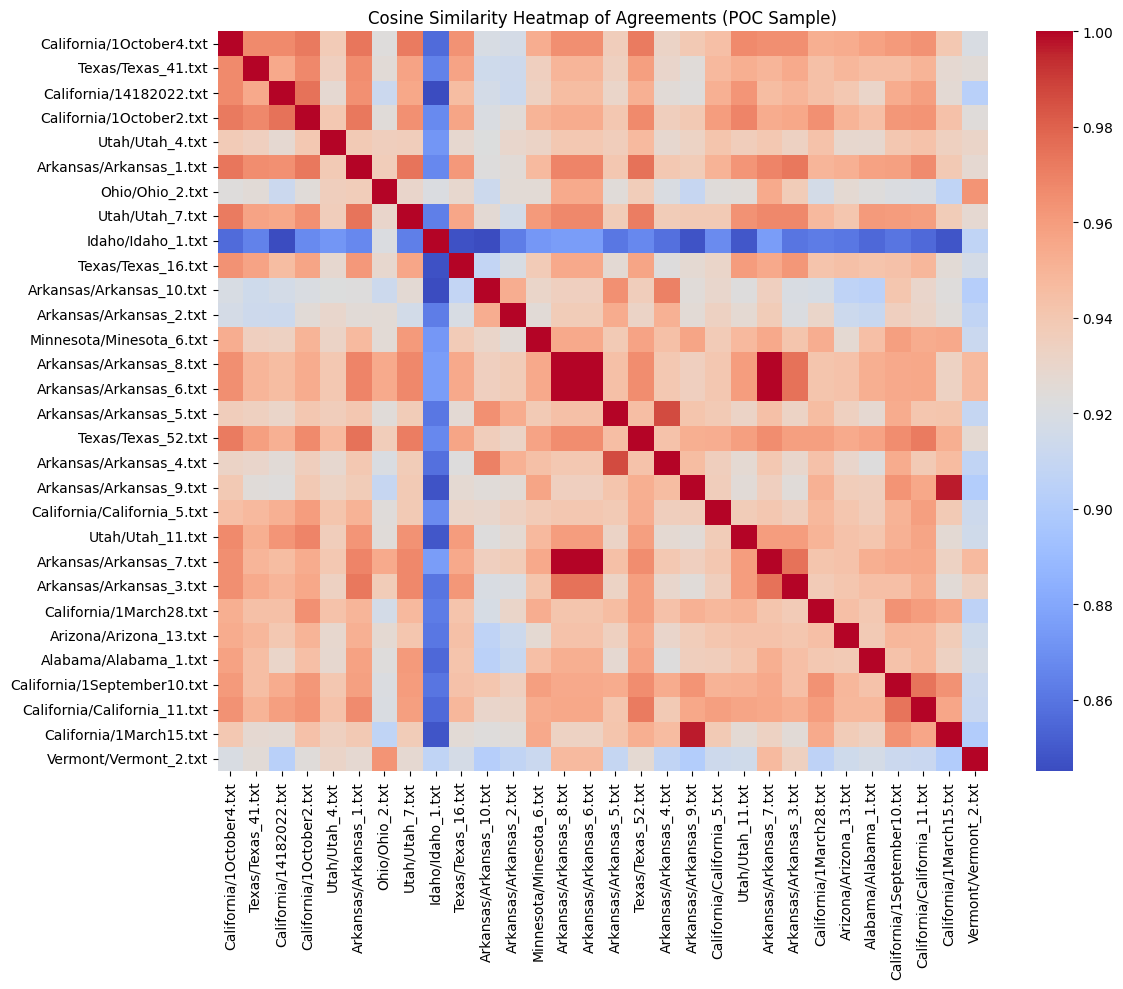

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Only for small POC (30 agreements) — otherwise too big
plt.figure(figsize=(12,10))
sns.heatmap(sim_matrix, xticklabels=sample_keys, yticklabels=sample_keys, cmap="coolwarm", annot=False)
plt.title("Cosine Similarity Heatmap of Agreements (POC Sample)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Comment:** *We see that some agreements repeate across states or repeat within one state - they are copies (example: Arkanas_9.txt & 1March15.txt, Arkanas_8.txt & Arkanas_7.txt)*

# Semantic Clustering (UMAP & HDBSCAN)

**Removing duplicates before clustering**

In [16]:
# Removing of second element of each duplicate pair
duplicate_keys = set(d[1] for d in duplicates)
cluster_keys = [k for k in sample_keys if k not in duplicate_keys]
cluster_texts = [agreements[k] for k in cluster_keys]


**Embed texts with Legal-SBERT (reuse model)**

In [17]:
embeddings_cluster = model.encode(
    cluster_texts,
    convert_to_numpy=True,
    normalize_embeddings=True
)


**Dimensionality reduction with UMAP**

In [18]:
import umap

umap_model = umap.UMAP(
    n_neighbors=10,
    n_components=2,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)

umap_embeddings = umap_model.fit_transform(embeddings_cluster)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


**Clustering with HDBSCAN**

In [19]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3,
    metric="euclidean",
    cluster_selection_method="eom"
)

cluster_labels = clusterer.fit_predict(umap_embeddings)


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


**Visualization of clusters**

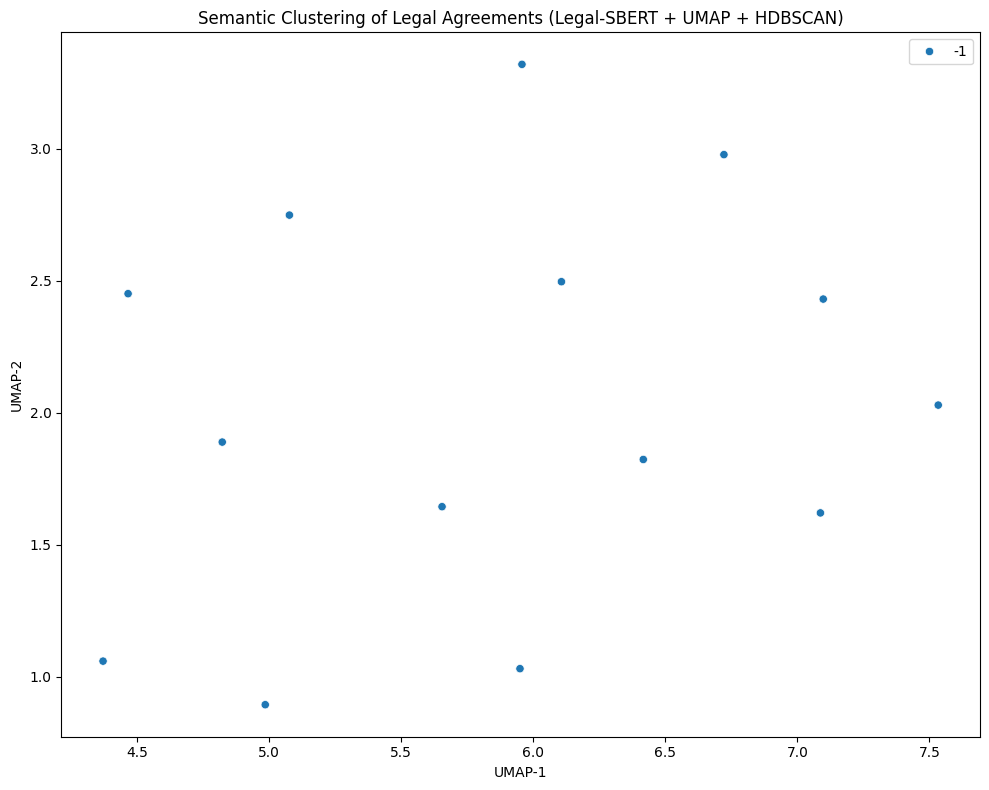

In [20]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    hue=cluster_labels,
    palette="tab10",
    legend="full"
)

plt.title("Semantic Clustering of Legal Agreements (Legal-SBERT + UMAP + HDBSCAN)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


Note:
* -1 → noise points

  * These are agreements that HDBSCAN thinks don’t belong to any dense cluster.
  * They are “outliers” or unique agreements.
  * Often agreements that are very short, very long, or have unusual clauses.

* 0, 1, 2, … → real clusters

  * HDBSCAN assigns a non-negative integer to each dense cluster it finds.
  * Each cluster contains agreements that are semantically similar according to Legal‑SBERT embeddings.

**Comment:** In our case many of agreements were labeled as -1 (so outliers) but its a normal for small subset of data for our POC (in final phase where we will consider full dataset we we expect a lower proportion of outliers). Additionally, for our subset we expected small amount of clusters as we have small amount of agreements inside it (30), in final phase we expect see more clusters.

**Inspection of clusters contents**

In [21]:
import pandas as pd

cluster_df = pd.DataFrame({
    "Agreement": cluster_keys,
    "Cluster": cluster_labels,
    "Text": cluster_texts,
})

# Show agreements per cluster
for cid in sorted(cluster_df["Cluster"].unique()):
    print(f"\n🔹 Cluster {cid}")
    display(cluster_df[cluster_df["Cluster"] == cid][["Agreement"]])



🔹 Cluster -1


,Agreement
0,Texas/Texas_41.txt
1,Utah/Utah_4.txt
2,Idaho/Idaho_1.txt
3,Texas/Texas_16.txt
4,Arkansas/Arkansas_10.txt
5,Arkansas/Arkansas_2.txt
6,Minnesota/Minesota_6.txt
7,California/California_5.txt
8,Utah/Utah_11.txt
9,Arkansas/Arkansas_7.txt


What is interesting for this subset (and we can expect it also for whol dataset) is that agreements that belongs to the same state are diffrent, not consider the same topic. We can assume that this is because we do not want to repeat the same subject in different agreements. A new agreement should concern something new, and when changes are made to a subject covered in an old agreement, that agreement should be updated rather than a new one created.

## Clusters interpretation

In [22]:
import json

# Function to load JSON cleaned text for a single file
def load_ocr_json_with_pages(path: str) -> str:
    """Reconstruct cleaned text from OCR JSON with page markers"""
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    out_lines = []
    for p_idx, page in enumerate(data.get("pages", []), start=1):
        out_lines.append(f"[[PAGE={p_idx}]]")
        for block in page.get("blocks", []):
            for line in block.get("lines", []):
                words = [w.get("value","") for w in line.get("words", []) if w.get("value")]
                if words:
                    out_lines.append(" ".join(words))
        out_lines.append("")  # blank line between pages

    text = "\n".join(out_lines)
    # normalize whitespace
    text = re.sub(r"[ \t]+"," ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

# -----------------------------
# Build cluster_texts_json list for cluster_keys
# -----------------------------
cluster_texts_json = []

for k in cluster_keys:
    state, filename = k.split("/")  # e.g., "Texas", "Texas_14.txt"
    json_fname = filename.replace(".txt", ".json")
    json_path = os.path.join(ocr_dir, state, json_fname)

    if os.path.exists(json_path):
        cluster_texts_json.append(load_ocr_json_with_pages(json_path))
    else:
        # fallback to raw txt if JSON missing
        print(f"⚠️ JSON not found for {k}, using raw TXT instead")
        cluster_texts_json.append(cluster_texts[cluster_keys.index(k)])

In [23]:
cluster_df["TextJSON"] = cluster_texts_json


In [24]:
import re

# Lista wszystkich stanów USA (do detekcji w tekście)
US_STATES = [
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut",
    "Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa",
    "Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
    "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire",
    "New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio",
    "Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota",
    "Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia",
    "Wisconsin","Wyoming"
]

# -----------------------------
# Function to detect state(s) mentioned in cleaned JSON text
# -----------------------------
def extract_states(text):
    found = set()
    for state in US_STATES:
        # Case-insensitive search
        if re.search(rf"\b{state}\b", text, re.IGNORECASE):
            found.add(state)
    return list(found) if found else ["Unknown"]

# -----------------------------
# Apply to cluster_df
# -----------------------------
cluster_df["Partners"] = cluster_df["TextJSON"].apply(extract_states)

# If multiple states are detected, join them for display
cluster_df["PartnersDisplay"] = cluster_df["Partners"].apply(lambda x: ", ".join(x))

# Word count for detail
cluster_df["WordCount"] = cluster_df["Text"].apply(lambda x: len(x.split()))




🔹 Cluster -1 (N=14)
Top keywords: ['parties', 'agreement', 'state', 'party', 'trade', 'between', 'program', 'each', 'other', 'programs', 'states', 'page', 'its', 'article', 'not']
Partner states: ['Texas', 'Utah', 'Idaho', 'Arkansas', 'Minnesota', 'California', 'Arizona', 'Alabama']


/tmp/ipython-input-2455657187.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


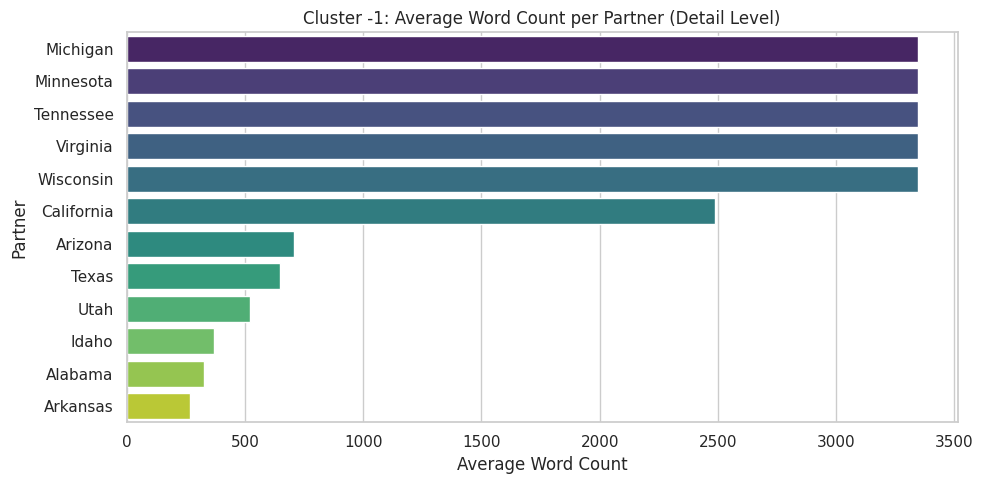

In [25]:
from collections import Counter
import re

# Add JSON cleaned text to cluster_df
# -----------------------------
# Make sure cluster_texts_json exists and matches cluster_keys
cluster_df["TextJSON"] = cluster_texts_json
cluster_df["TextTXT"] = cluster_texts  # your raw txt

# -----------------------------
# Step 8: Cluster interpretation (Top 15 keywords from JSON cleaned text)
# -----------------------------
stopwords = set([
    "and", "with", "it", "is", "are", "the", "a", "an", "of", "in", "on",
    "for", "to", "by", "at", "from", "as", "that", "this", "be", "or", "which",
    "both", "their", "from", "your", 'i', 'will', 'e', 's', 'de', 'r', 'à', 'y', 'shall',
    'missouri', 'alaska', 'new hampshire', 'illinois', 'virginia', 'washington', 'vermont', 'south dakota', 'georgia', 'connecticut', 'alabama',
    'oklahoma', 'colorado', 'ohio', 'maine', 'mississippi', 'utah', 'south carolina', 'any',
    'delaware', 'indiana', 'arkansas', 'iowa', 'new jersey', 'wisconsin', 'michigan', 'arizona',
    'massachusetts', 'montana', 'new york', 'wyoming', 'minnesota', 'west virginia', 'north dakota', 'florida', 'kentucky', 'louisiana', 'maryland', 'texas', 'hawaii', 'rhode island',
    'kansas', 'pennsylvania', 'north carolina', 'nebraska', 'tennessee', 'idaho', 'oregon', 'nevada', 'california', 'new mexico'
])


def get_top_words(texts, n=15):
    words = []
    for t in texts:
        t_clean = re.sub(r"[^a-zA-Z]", " ", t.lower())
        words += [w for w in t_clean.split() if w not in stopwords and len(w)>2]
    return Counter(words).most_common(n)

cluster_summary = {}
for cid in sorted(cluster_df["Cluster"].unique()):
    texts = cluster_df[cluster_df["Cluster"] == cid]["TextJSON"].tolist()
    top_words = get_top_words(texts)
    partners = cluster_df[cluster_df["Cluster"] == cid]["Agreement"].apply(lambda x: x.split("/")[0]).unique().tolist()
    cluster_summary[cid] = {
        "TopWords": top_words,
        "Partners": partners,
        "NumAgreements": len(texts)
    }

# Display cluster interpretations
for cid, info in cluster_summary.items():
    print(f"\n🔹 Cluster {cid} (N={info['NumAgreements']})")
    print("Top keywords:", [w[0] for w in info["TopWords"]])
    print("Partner states:", info["Partners"])

# Explode partners list so each partner has separate row
exploded_df = cluster_df.explode("Partners")

avg_words_cluster = exploded_df.groupby(["Cluster","Partners"])["WordCount"].mean().reset_index()
avg_words_cluster = avg_words_cluster.sort_values(["Cluster","WordCount"], ascending=[True, False])

# -----------------------------
# Visualization: bar chart of average word count per partner per cluster
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
unique_clusters = sorted(cluster_df["Cluster"].unique())

for cid in unique_clusters:
    top_partners = avg_words_cluster[avg_words_cluster["Cluster"] == cid]

    plt.figure(figsize=(10,5))
    sns.barplot(
        data=top_partners,
        x="WordCount",
        y="Partners",
        palette="viridis",
        orient="h"
    )
    plt.title(f"Cluster {cid}: Average Word Count per Partner (Detail Level)")
    plt.xlabel("Average Word Count")
    plt.ylabel("Partner")
    plt.tight_layout()
    plt.show()

Clustering of the agreements revealed three main groups.

**Cluster 0** – Cultural, Educational, and Institutional Exchange Agreements

* Top keywords:
film, ministry, education, programs, teachers, memorandum, understanding, spain, sonora

* Partner states:
Arizona, California, Utah

* This cluster clearly represents cultural and educational cooperation, including:
education and teacher exchange programs,
cultural initiatives (e.g., film, language, heritage),
institutional cooperation between ministries and public offices.
The presence of terms such as “memorandum” and “understanding” indicates that these agreements are typically Memoranda of Understanding (MoUs), often emphasizing symbolic or programmatic collaboration rather than binding commitments.

**Cluster 1** – Administrative, Legal, and Institutional Cooperation

* Top keywords:
authority, supervisory, confidentiality, participants, undertaking, international, college
* Partner states:
Texas, Arkansas, Minnesota
* This cluster captures agreements focused on formal administrative and institutional collaboration, including:
cooperation between authorities and supervisory bodies,
information exchange under confidentiality rules,
structured international or inter-institutional undertakings.

**Cluster -1** – Environmental, Regulatory, and Multi-topic Agreements (Noise / Heterogeneous)

* Top keywords:
state, forest, climate, emission, fire, protection, compact, commission, license
* Partner states:
Arkansas, Texas, Connecticut, California
* This cluster groups together heterogeneous and cross-domain agreements, primarily related to:
environmental protection,
forestry and fire management,
climate and emissions,
regulatory or compact-based cooperation.



# Metadata Normalization & Consistency Check

Purpose:

Extracted metadata from legal and policy documents is often inconsistent, noisy, and non-standardized, which limits its usability for downstream analysis.

In [26]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.3 MB/s eta 0:00:00


**Build metadata dataset**

In [27]:
# -----------------------------
# Ensure all lists are same length as sample_keys
# -----------------------------
n = len(sample_keys)

# PartnerRaw from cluster_df (or Unknown if missing)
partners_raw = []
for key in sample_keys:
    row = cluster_df[cluster_df["Agreement"] == key]
    if not row.empty:
        partners_raw.append(row["PartnersDisplay"].values[0])
    else:
        partners_raw.append("Unknown")

# Agreement type (POC heuristic)
agreement_types = ["MOU" if "mou" in text.lower() else "Agreement" for text in texts]
agreement_types = (agreement_types * ((n // len(agreement_types)) + 1))[:n]

# Start / End dates (POC placeholders)
start_dates = (["January 15, 2023", "15 Jan 2023", "2023-01-15", "01/15/2023"]
               * ((n // 4) + 1))[:n]

end_dates = (["Dec 31 2025", "31/12/2025", "2025-12-31", "12/31/2025"]
             * ((n // 4) + 1))[:n]

# -----------------------------
# Build metadata DataFrame
# -----------------------------
metadata = pd.DataFrame({
    "Agreement": sample_keys,
    "PartnerRaw": partners_raw,
    "AgreementTypeRaw": agreement_types,
    "StartDateRaw": start_dates,
    "EndDateRaw": end_dates
})

print("✅ Metadata DataFrame created successfully")
metadata.head(20)


✅ Metadata DataFrame created successfully


,Agreement,PartnerRaw,AgreementTypeRaw,StartDateRaw,EndDateRaw
0,California/1October4.txt,Unknown,Agreement,"January 15, 2023",Dec 31 2025
1,Texas/Texas_41.txt,Texas,MOU,15 Jan 2023,31/12/2025
2,California/14182022.txt,Unknown,Agreement,2023-01-15,2025-12-31
3,California/1October2.txt,Unknown,Agreement,01/15/2023,12/31/2025
4,Utah/Utah_4.txt,Utah,Agreement,"January 15, 2023",Dec 31 2025
5,Arkansas/Arkansas_1.txt,Unknown,Agreement,15 Jan 2023,31/12/2025
6,Ohio/Ohio_2.txt,Unknown,MOU,2023-01-15,2025-12-31
7,Utah/Utah_7.txt,Unknown,Agreement,01/15/2023,12/31/2025
8,Idaho/Idaho_1.txt,Idaho,Agreement,"January 15, 2023",Dec 31 2025
9,Texas/Texas_16.txt,Texas,MOU,15 Jan 2023,31/12/2025


**Merge matadate dataset just created with cluster_df dataset**
)

In [36]:
import pandas as pd
from dateutil import parser
from rapidfuzz import process, fuzz

# -----------------------------
# Ensure all lists are same length as sample_keys
# -----------------------------
n = len(sample_keys)

# PartnerRaw from cluster_df (or Unknown if missing)
partners_raw = []
for key in sample_keys:
    row = cluster_df[cluster_df["Agreement"] == key]
    if not row.empty:
        partners_raw.append(row["PartnersDisplay"].values[0])
    else:
        partners_raw.append("Unknown")

# Agreement type (POC heuristic)
agreement_types = ["MOU" if "mou" in text.lower() else "Agreement" for text in texts]
if len(agreement_types) < n:
    # pad or truncate
    agreement_types = (agreement_types * ((n // len(agreement_types)) + 1))[:n]
else:
    agreement_types = agreement_types[:n]

# Start / End dates (POC placeholders)
start_dates = (["January 15, 2023", "15 Jan 2023", "2023-01-15", "01/15/2023"]
               * ((n // 4) + 1))[:n]
end_dates = (["Dec 31 2025", "31/12/2025", "2025-12-31", "12/31/2025"]
             * ((n // 4) + 1))[:n]

# -----------------------------
# Build metadata DataFrame
# -----------------------------
metadata = pd.DataFrame({
    "Agreement": sample_keys,
    "PartnerRaw": partners_raw,
    "AgreementTypeRaw": agreement_types,
    "StartDateRaw": start_dates,
    "EndDateRaw": end_dates
})

print("✅ Metadata DataFrame created successfully")
print(metadata.head())


✅ Metadata DataFrame created successfully
                  Agreement PartnerRaw AgreementTypeRaw      StartDateRaw  \
0  California/1October4.txt    Unknown        Agreement  January 15, 2023   
1        Texas/Texas_41.txt      Texas              MOU       15 Jan 2023   
2   California/14182022.txt    Unknown        Agreement        2023-01-15   
3  California/1October2.txt    Unknown        Agreement        01/15/2023   
4           Utah/Utah_4.txt       Utah        Agreement  January 15, 2023   

    EndDateRaw  
0  Dec 31 2025  
1   31/12/2025  
2   2025-12-31  
3   12/31/2025  
4  Dec 31 2025  


In [37]:
metadata = metadata.merge(
    cluster_df[["Agreement", "Text"]],
    on="Agreement",
    how="left")

metadata.head(20)

,Agreement,PartnerRaw,AgreementTypeRaw,StartDateRaw,EndDateRaw,Text
0,California/1October4.txt,Unknown,Agreement,"January 15, 2023",Dec 31 2025,NaN
1,Texas/Texas_41.txt,Texas,MOU,15 Jan 2023,31/12/2025,S\nMANITOBA\nTEXAS\nMEMORANDUM OF UNDERSTANDIN...
2,California/14182022.txt,Unknown,Agreement,2023-01-15,2025-12-31,NaN
3,California/1October2.txt,Unknown,Agreement,01/15/2023,12/31/2025,NaN
4,Utah/Utah_4.txt,Utah,Agreement,"January 15, 2023",Dec 31 2025,USBE Ageement Number: USBE180067MOU\nO\nCheckp...
5,Arkansas/Arkansas_1.txt,Unknown,Agreement,15 Jan 2023,31/12/2025,NaN
6,Ohio/Ohio_2.txt,Unknown,MOU,2023-01-15,2025-12-31,NaN
7,Utah/Utah_7.txt,Unknown,Agreement,01/15/2023,12/31/2025,NaN
8,Idaho/Idaho_1.txt,Idaho,Agreement,"January 15, 2023",Dec 31 2025,Agreement for the Establishment\nof a Sister S...
9,Texas/Texas_16.txt,Texas,MOU,15 Jan 2023,31/12/2025,LETTER OF INTENT BETWEEN THE DEPARTMENT OF\nTR...


**Controlled vocabularies (schema-level normalization)**

In [38]:
CANONICAL_AGREEMENT_TYPES = {
    "Memorandum of Understanding": ["mou", "memorandum of understanding"],
    "Sister Cities Agreement": [
    r"sister\s+cities\s+international",
    r"sister\s+cities\s+int\.?",
    r"sister\s+city\s+international",
    r"sister\s+cities\b",
    r"sister\s+city\b",
    r"\bsci\b"],
    "Cooperation Agreement": ["cooperation agreement", "collaboration agreement"],

}

CANONICAL_PARTNERS = sorted(
    {
        p.strip()
        for partners in metadata["PartnerRaw"].dropna()
        for p in partners.split(",")
    }
)


**RapidFuzz normalization (partner names)**

In [39]:
def normalize_partners(value, threshold=80):
    if pd.isna(value):
        return value

    partners = [p.strip() for p in value.split(",")]
    normalized = []

    for p in partners:
        match, score, _ = process.extractOne(
            p, CANONICAL_PARTNERS, scorer=fuzz.token_sort_ratio
        )
        normalized.append(match if score >= threshold else p)

    return ", ".join(sorted(set(normalized)))


metadata["PartnerNorm"] = metadata["PartnerRaw"].apply(normalize_partners)


**Agreement type normalization (rule + fuzzy)**

In [40]:
def normalize_agreement_type(value):
    if pd.isna(value):
        return None

    v = value.lower()
    for canonical, variants in CANONICAL_AGREEMENT_TYPES.items():
        for var in variants:
            if var in v:
                return canonical
    return value


metadata["AgreementTypeNorm"] = metadata["AgreementTypeRaw"].apply(
    normalize_agreement_type
)


**Uniform date formatting (YYYY-MM-DD)**

In [41]:
def normalize_date(value):
    if pd.isna(value):
        return None
    try:
        return parser.parse(value, fuzzy=True).strftime("%Y-%m-%d")
    except Exception:
        return None


metadata["StartDateNorm"] = metadata["StartDateRaw"].apply(normalize_date)
metadata["EndDateNorm"] = metadata["EndDateRaw"].apply(normalize_date)


**LLM-assisted normalization**

In [42]:
def infer_agreement_type_from_text(text):
    if pd.isna(text):
        return None

    t = text.lower()
    if "sister city" in t or "sister cities" in t:
        return "Sister Cities Agreement"
    if "memorandum of understanding" in t or "mou" in t:
        return "Memorandum of Understanding"
    if "cooperation" in t or "collaboration" in t:
        return "Cooperation Agreement"
    return None


metadata["AgreementTypeFinal"] = metadata.apply(
    lambda r: r["AgreementTypeNorm"]
    if pd.notna(r["AgreementTypeNorm"])
    else infer_agreement_type_from_text(r["Text"]),
    axis=1
)


**Consistency check (rule-based, metadata vs source text)**

In [43]:
def rule_based_consistency(row):
    score = 0
    checks = 0
    text = str(row["Text"]).lower()

    if pd.notna(row["AgreementTypeFinal"]):
        checks += 1
        if row["AgreementTypeFinal"].lower() in text:
            score += 1

    if pd.notna(row["StartDateNorm"]):
        checks += 1
        if row["StartDateNorm"][:4] in text:
            score += 1

    if pd.notna(row["PartnerNorm"]):
        checks += 1
        if any(p.lower() in text for p in row["PartnerNorm"].split(", ")):
            score += 1

    return score / checks if checks > 0 else 0


metadata["RuleConsistency"] = metadata.apply(
    rule_based_consistency, axis=1
)


**Embedding-based consistency (SOTA)**

In [44]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

model = SentenceTransformer("bhavyagiri/InLegal-SBERT")


def embedding_consistency(metadata_value, source_text, threshold=0.30):
    """
    Returns cosine similarity score between metadata value
    and source text. Low score = possible inconsistency.
    """
    if pd.isna(metadata_value) or pd.isna(source_text):
        return np.nan

    emb_meta = model.encode(str(metadata_value), convert_to_tensor=True)
    emb_text = model.encode(str(source_text), convert_to_tensor=True)

    return float(util.cos_sim(emb_meta, emb_text))


# Apply to agreement type vs document text
metadata["AgreementTypeEmbeddingScore"] = metadata.apply(
    lambda row: embedding_consistency(
        row.get("AgreementTypeNormalized", row["AgreementTypeRaw"]),
        row["Text"]
    ),
    axis=1
)


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

**Reliability score**

In [45]:
def compute_reliability(row):
    scores = []

    # Rule-based: agreement type appears in text
    if not pd.isna(row["Text"]):
        if row["AgreementTypeRaw"].lower() in row["Text"].lower():
            scores.append(1.0)
        else:
            scores.append(0.5)

    # Embedding-based agreement
    if not pd.isna(row["AgreementTypeEmbeddingScore"]):
        scores.append(row["AgreementTypeEmbeddingScore"])

    if not scores:
        return 0.0

    return round(float(np.mean(scores)), 3)


metadata["ReliabilityScore"] = metadata.apply(
    compute_reliability,
    axis=1
)


In [47]:
metadata[["Agreement", "AgreementTypeRaw", "ReliabilityScore"]].head(20)


,Agreement,AgreementTypeRaw,ReliabilityScore
0,California/1October4.txt,Agreement,0.000
1,Texas/Texas_41.txt,MOU,0.463
2,California/14182022.txt,Agreement,0.000
3,California/1October2.txt,Agreement,0.000
4,Utah/Utah_4.txt,Agreement,0.708
5,Arkansas/Arkansas_1.txt,Agreement,0.000
6,Ohio/Ohio_2.txt,MOU,0.000
7,Utah/Utah_7.txt,Agreement,0.000
8,Idaho/Idaho_1.txt,Agreement,0.681
9,Texas/Texas_16.txt,MOU,0.462


**Comment:** ReliabilityScore:
* 0.0	Not verifiable (missing or empty text)
* 0.4 – 0.6	Partial / weak consistency
* \> 0.65	High confidence metadata

**Note:** *In final experiment we want to distinguish “missing text” from “low reliability”, improve rule-based check for agreement types (that means consider not only 'agreements' but also: "memorandum",
    "agreement",
    "undertaking",
    "arrangement",
    "declaration")

**Agreement categories (semantic labels)**

In [58]:
AGREEMENT_CATEGORIES = {
    "Sister Cities / Cultural Exchange": (
        "sister cities, cultural exchange, education, people to people cooperation, "
        "arts, film, language, community programs"
    ),
    "Economic & Trade Cooperation": (
        "trade, investment, economic development, business cooperation, innovation"
    ),
    "Environmental & Climate Cooperation": (
        "climate change, forests, emissions, sustainability, environmental protection"
    ),
    "Administrative / Legal Cooperation": (
        "confidentiality, supervision, legal framework, administrative cooperation"
    ),
    "Education & Research": (
        "universities, students, academic exchange, research collaboration"
    ),
    "Environmental & Climate Cooperation": (
    "climate, forest, emissions, environmental protection, sustainability"
),
"Administrative / Legal Cooperation": (
    "confidentiality, supervision, legal framework, administrative cooperation"
)

}


**Note:** *The number of semantic categories is not constrained by the number of clusters. Clustering is used as an exploratory tool to identify latent textual groupings, while categorization assigns interpretable policy-relevant labels at the document level. A single cluster may contain agreements spanning multiple semantic categories.*

**Embed category definitions**

In [59]:
category_names = list(AGREEMENT_CATEGORIES.keys())
category_texts = list(AGREEMENT_CATEGORIES.values())

category_embeddings = model.encode(
    category_texts, convert_to_tensor=True
)


**Categorize agreements by text**

In [60]:
from sentence_transformers import util

def categorize_agreement(text, threshold=0.30):
    if pd.isna(text):
        return "Uncategorized"

    text_emb = model.encode(text, convert_to_tensor=True)
    scores = util.cos_sim(text_emb, category_embeddings)[0]

    best_idx = int(scores.argmax())
    best_score = float(scores[best_idx])

    if best_score < threshold:
        return "Uncategorized"

    return category_names[best_idx]


metadata["AgreementCategory"] = metadata["Text"].apply(
    categorize_agreement
)


**Category confidence**

In [61]:
def category_confidence(text):
    if pd.isna(text):
        return 0.0
    emb = model.encode(text, convert_to_tensor=True)
    return float(util.cos_sim(emb, category_embeddings).max())


metadata["CategoryConfidence"] = metadata["Text"].apply(
    category_confidence
)


**Quick sanity check**

In [62]:
metadata["AgreementCategory"].value_counts()


,count
AgreementCategory,
Uncategorized,16
Sister Cities / Cultural Exchange,14


It means:

~47% of agreements clearly match your strongest semantic category

~53% do not confidently match any predefined category.

For final deliver we expect better result as we will have more agreements.

Uncategorized usually means one of:
* Missing text	(no content to embed)
* Very generic legal text	(“Agreement between the State of X…”)
* Falls outside your label set	(E.g. environmental, administrative)
* Threshold too high	(conservative assignment)